In [1]:
# python libraries
import os
import sys
import dataclasses
from datetime import datetime
from pathlib import Path
from operator import methodcaller
from collections import OrderedDict
from dataclasses import dataclass
from typing import (
    List,
    Tuple,
    Dict,
    Any,
    Mapping,
    Callable
)
from enum import Enum
# adding the path
if not str(Path(os.getcwd()).parent) in sys.path:
    sys.path.append(str(Path(os.getcwd()).parent))

# numpy
import numpy as np

# torch
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import (
    transforms,
    datasets
    )
from torch.utils.data import DataLoader

try:
    from torchmetrics import Accuracy
except:
    print(f"[INFO] Installing the torchmetrics")
    %pip install torchmetrics
    from torchmetrics import Accuracy

try:
    import torchinfo
except:
    print(f"[INFO] Installing the torchinfo")
    %pip install torchinfo
    import torchinfo

# helper function
try:
    import my_helper as helper
except:
    print("[INFO] Downloading the helper function from github")
    import requests
    response = requests.get("https://raw.githubusercontent.com/Lashi0812/PyTorch2/master/my_helper.py")
    with open("my_helper.py" ,"wb") as f:
        f.write(response.content)
    import my_helper as helper

[INFO] Installing the torchmetrics
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 10.2 MB/s eta 0:00:00
[INFO] Installing the torchinfo
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[INFO] Downloading the helper function from github


In [2]:
## Connect Persistence memory
try :
    from google.colab import drive

    # Paths
    DRIVE_PATH = Path("/content/drive")
    MODEL_SAVE_PATH = Path("/content/drive/Othercomputers/My PC/drive/models")

    # mount drive
    drive.mount(str(DRIVE_PATH))
except:
    MODEL_SAVE_PATH = Path(os.getcwd())/"models"

Mounted at /content/drive


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# GoogleNet Architecture

## Inception Module

In [4]:
@dataclass(eq=False)
class Inception(nn.Module):
    """
    Create the inception module with given shape of output channel of following shape
    (c1,c2,c3,c4) and Branch in following structure ((1x1),(1x1,3x3),(1x1,5x5),(1x1))
    """
    c1:int
    c2:Tuple[int,int]
    c3:Tuple[int,int]
    c4:int
    
    def __post_init__(self):
        super().__init__()
        # Branch1 of 1x1 conv this will concentrate the local region
        self.b1_1 = nn.LazyConv2d(out_channels=self.c1,kernel_size=1,stride=1,padding=0)
        
        #! Filter with different size inspired form Gabor filter to handel the multiple scale 
        # Branch 2 for 3x3 conv
        #? before passing into the 3x3 conv we reduce the dimension of filter by passing them 1x1 conv
        self.b2_1 = nn.LazyConv2d(out_channels=self.c2[0],kernel_size=1,stride=1,padding=0)
        #? padding to have input and output size same
        self.b2_2 = nn.LazyConv2d(out_channels=self.c2[1],kernel_size=3,stride=1,padding=1)
        
        # Branch 3 for 5x5 conv
        #? dimension reduction
        self.b3_1 = nn.LazyConv2d(out_channels=self.c3[0],kernel_size=1,stride=1,padding=0)
        self.b3_2 = nn.LazyConv2d(out_channels=self.c3[1],kernel_size=5,stride=1,padding=2)
        
        # Branch 4 for max pooling
        self.b4_1 = nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.b4_2 = nn.LazyConv2d(out_channels=self.c4,kernel_size=1,stride=1,padding=0)
        
    def forward(self,x:torch.Tensor)->torch.Tensor:
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        
        return torch.cat((b1,b2,b3,b4),dim=1)

## GoogleNet

In [5]:
@dataclass(eq=False)
class GoogleNet(helper.Classifier):
    lr:int = 0.01
    num_classes = 10
    
    def __post_init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self.b1(),self.b2(),self.b3(),self.b4(),
            self.b5(),nn.LazyLinear(self.num_classes)
        )
    
    
    def b1(self):
        """
        The stem is very similar to AlexNet and LeNet
        """
        return nn.Sequential(
            nn.LazyConv2d(out_channels=64,kernel_size=7,stride=2,padding=3),
            nn.ReLU(),nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
            )
    
    def b2(self):
        return nn.Sequential(
            nn.LazyConv2d(out_channels=64,kernel_size=1),nn.ReLU(),
            nn.LazyConv2d(out_channels=192,kernel_size=3,padding=1),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        )
        
    def b3(self):
        """
        With 2 inception module 
        
        1st Inception Module:
            output channel = 256
            output ratio 2:4:1:1 (64,128,32,32)  
            dimension reduce 
                1/2 ---> 2nd branch of 3x3 ====> 192/2  = 96
                1/12 --> 3rd branch of 5x5 ====> 192/12 = 16
        
        2nd Inception Module:
            output channel = 480
            output ratio 4:6:3:2 (128,192,96,64)
            dimension reduce 
                1/2 ---> 2nd branch of 3x3 ====> 256/2  = 128
                1/8  --> 3rd branch of 5x5 ====> 256/12 = 32
        """
        return nn.Sequential(
            Inception(64,(96,128),(16,32),32),
            Inception(128,(128,192),(32,96),64),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        )
    
    def b4(self):
        """
        With 5 Inception Module
        
        1st Inception Module:
            output channel = 512
            output ratio 12:13:3:4 (192,208,48,64)
            dimension reduce 
                1/5 ---> 2nd branch of 3x3 ====> 480/5  = 96
                1/30 --> 3rd branch of 5x5 ====> 480/30 = 16
        .....        
        """
        return nn.Sequential(
            Inception(192, (96, 208), (16, 48), 64),
            Inception(160, (112, 224), (24, 64), 64),
            Inception(128, (128, 256), (24, 64), 64),
            Inception(112, (144, 288), (32, 64), 64),
            Inception(256, (160, 320), (32, 128), 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
    def b5(self):
        return nn.Sequential(
            Inception(256, (160, 320), (32, 128), 128),
            Inception(384, (192, 384), (48, 128), 128),
            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten()
            )
    
    @staticmethod
    def init_gNet(module):
        if isinstance(module,(nn.Linear,nn.Conv2d)):
            nn.init.kaiming_normal_(module.weight)

In [6]:
GoogleNet().layer_summary((1,1,96,96))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential      output shape :(1, 64, 24, 24)
Sequential      output shape :(1, 192, 12, 12)
Sequential      output shape :(1, 480, 6, 6)
Sequential      output shape :(1, 832, 3, 3)
Sequential      output shape :(1, 1024)
Linear          output shape :(1, 10)


In [7]:
torchinfo.summary(GoogleNet(),input_size=(1,1,96,96)  ,  col_width=14,depth=2,
    col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
    row_settings=["var_names"],
)

Layer (type (var_name))                  Kernel Shape   Output Shape   Param #        Mult-Adds
GoogleNet (GoogleNet)                    --             [1, 10]        --             --
├─Sequential (net)                       --             [1, 10]        --             --
│    └─Sequential (0)                    --             [1, 64, 24, 24] 3,200          7,372,800
│    └─Sequential (1)                    --             [1, 192, 12, 12] 114,944        66,207,744
│    └─Sequential (2)                    --             [1, 480, 6, 6] 552,432        79,550,208
│    └─Sequential (3)                    --             [1, 832, 3, 3] 2,809,168      101,130,048
│    └─Sequential (4)                    --             [1, 1024]      2,487,536      22,387,824
│    └─Linear (5)                        --             [1, 10]        10,250         10,250
Total params: 5,977,530
Trainable params: 5,977,530
Non-trainable params: 0
Total mult-adds (M): 276.66
Input size (MB): 0.04
Forward/backward pa

The size of the module is very less than compare to VGG.

In [8]:
model = GoogleNet(lr=0.01)
trainer = helper.Trainer(max_epochs=10,model_save_path=MODEL_SAVE_PATH)
data = helper.FashionMNIST(batch_size=128,resize=(96,96))
model.apply_init([next(iter(data.train_dataloader()))[0]],model.init_gNet)

Training the model in cuda


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/10 [00:00<?, ?it/s]

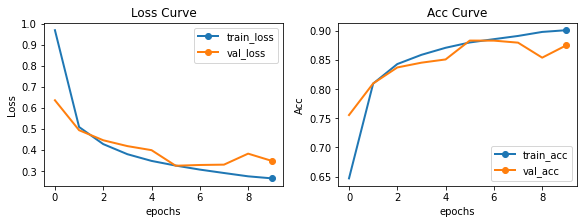

[Info] Saving the model at /content/drive/Othercomputers/My PC/drive/models/2023-02-05/GoogleNet-184340.pth


In [9]:
trainer.fit(model,data)